In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define paths for dataset and outputs
dataset_path = '/content/drive/MyDrive/CVPR/face_data/'  # Adjust this path as per your data location
output_path = '/content/drive/MyDrive/CVPR/Assignment-2/'  # Adjust this path for saving models/pickles

In [4]:
IMG_SIZE = 128  # Target image size for resizing
haarcascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'  # Haar cascade path

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(haarcascade_path)

# Prepare dataset
categories = os.listdir(dataset_path)  # Class names are the folder names
print("Categories:", categories)

Categories: ['Nazim', 'Tashrif', 'Emamul', 'Borno']


In [5]:
data = []
labels = []

In [6]:
# Process each category folder
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img_name)
            img_array = cv2.imread(img_path)  # Load image
            if img_array is None:
                print(f"Failed to load {img_path}")
                continue

            # Convert to grayscale for face detection
            gray_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # Crop the first detected face (if any)
            if len(faces) > 0:
                x, y, w, h = faces[0]  # Taking the first detected face
                face = img_array[y:y + h, x:x + w]
                face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))  # Resize to target size
                data.append(face)
                labels.append(category)  # Label as folder name
            else:
                print(f"No face detected in {img_path}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert to numpy arrays
data = np.array(data, dtype=np.float32) / 255.0  # Normalize pixel values
labels = np.array(labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Save category mapping for later use
category_names = {i: str(cat) for i, cat in enumerate(le.classes_)}  # Convert to native str
with open(os.path.join(output_path, "categories.pkl"), "wb") as file:
    pickle.dump(category_names, file)
print("Category mapping saved:", category_names)

Category mapping saved: {0: 'Borno', 1: 'Emamul', 2: 'Nazim', 3: 'Tashrif'}


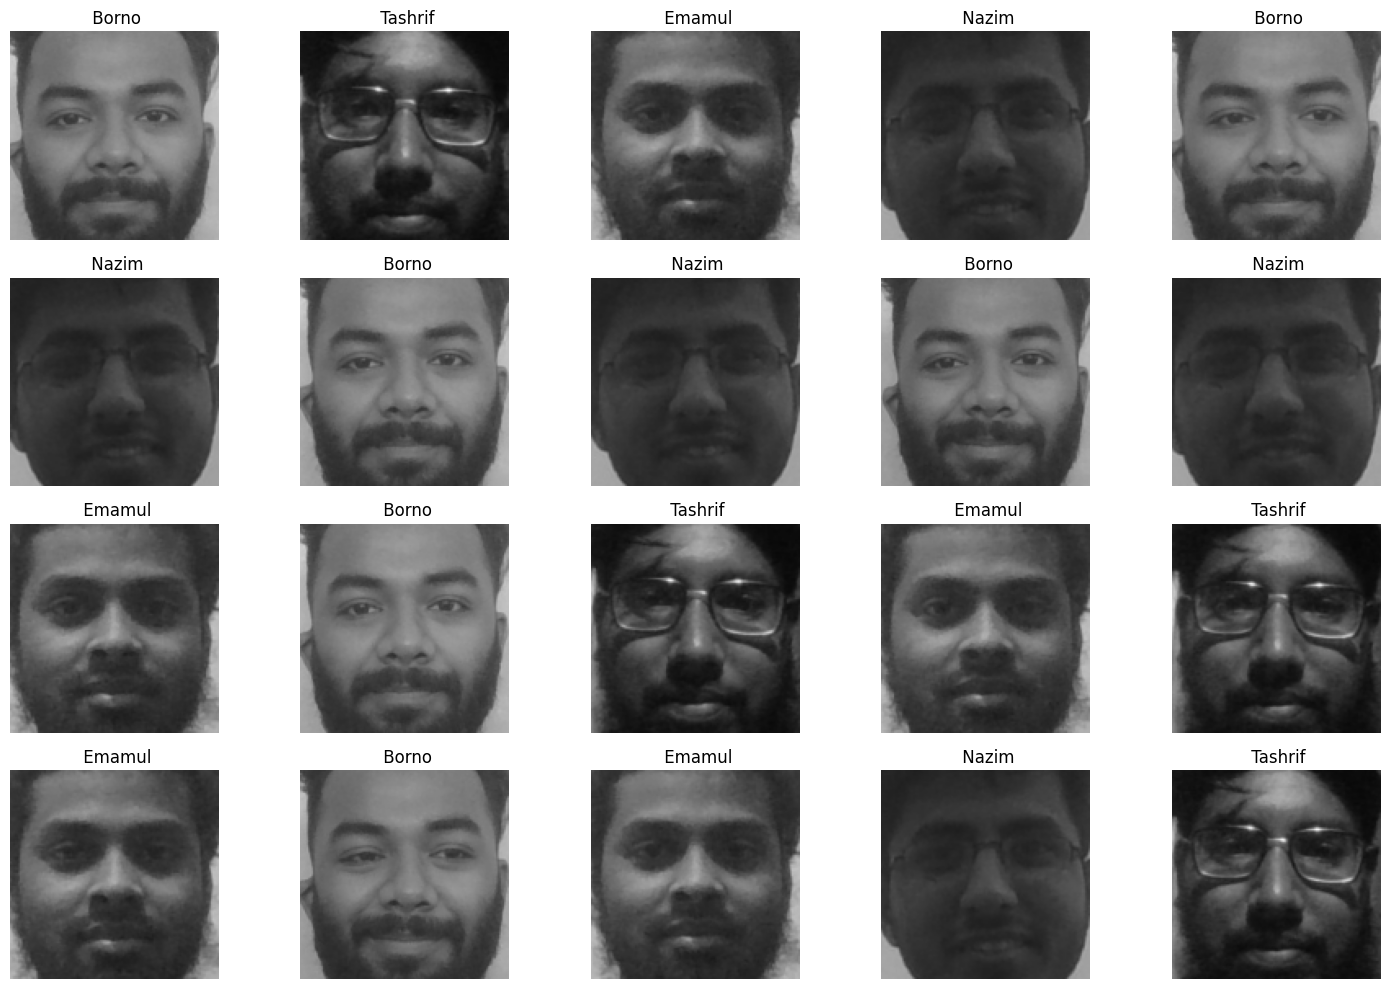

In [7]:
import random
import matplotlib.pyplot as plt

# Select 20 random indices from the dataset
random_indices = random.sample(range(len(data)), 20)

# Plot the images with their labels
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(data[idx])  # Display the image
    plt.title(f" {category_names[labels[idx]]}")  # Show the label
    plt.axis('off')  # Turn off axes for better visualization

plt.tight_layout()
plt.show()


In [8]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=121
)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))

# Print dataset shapes
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (160, 128, 128, 3)
Validation data shape: (40, 128, 128, 3)
Training labels shape: (160, 4)
Validation labels shape: (40, 4)


In [9]:
# Load MobileNetV2 with pre-trained weights and exclude top layers
mobilenet_base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze base model
mobilenet_base.trainable = False

# Define the new model
model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    Dropout(0.35),
    Dense(48, activation='relu'),
    Dropout(0.35),
    Dense(len(categories), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
batch_size = 32
epochs = 30

In [12]:
best_model_path = os.path.join(output_path, "best_model.keras")

checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Start training
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.2484 - loss: 1.9440
Epoch 1: val_loss improved from inf to 0.83139, saving model to /content/drive/MyDrive/CVPR/Assignment-2/best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 803ms/step - accuracy: 0.2591 - loss: 1.9022 - val_accuracy: 0.5750 - val_loss: 0.8314
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6670 - loss: 0.9494
Epoch 2: val_loss improved from 0.83139 to 0.34755, saving model to /content/drive/MyDrive/CVPR/Assignment-2/best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 664ms/step - accuracy: 0.6694 - loss: 0.9393 - val_accuracy: 0.9750 - val_loss: 0.3476
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8957 - loss: 0.4125
Epoch 3: val_loss improved from 0.34755 to 0.10551, saving model to /content/drive/MyDrive/CVPR/Assignment-2/best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accuracy: 0.8996 - loss: 0.4032 - val_accuracy: 1.0000 - val_loss: 0.1055
Epoch 4/30
5/5 ━━━━━━━━━━━━━━

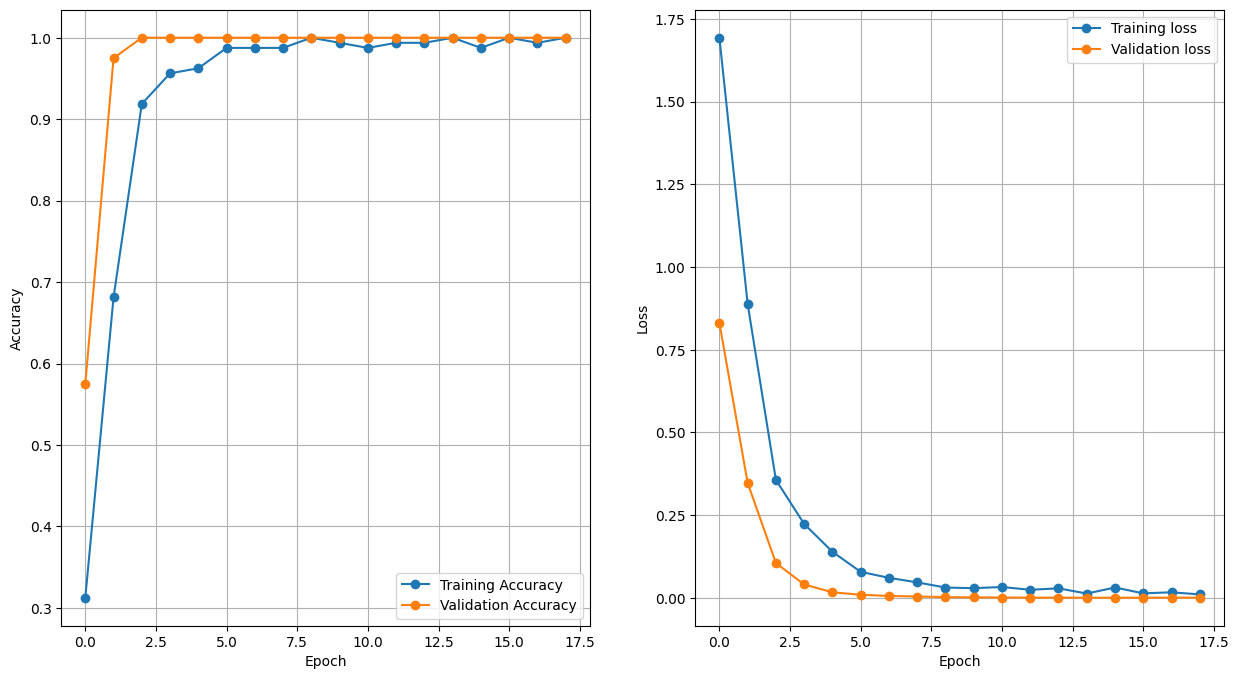

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='Training loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │        61,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,443,038 (9.32 MB)

 Trainable params: 61,684 (240.95 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 123,370 (481.92 KB)

Training complete.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


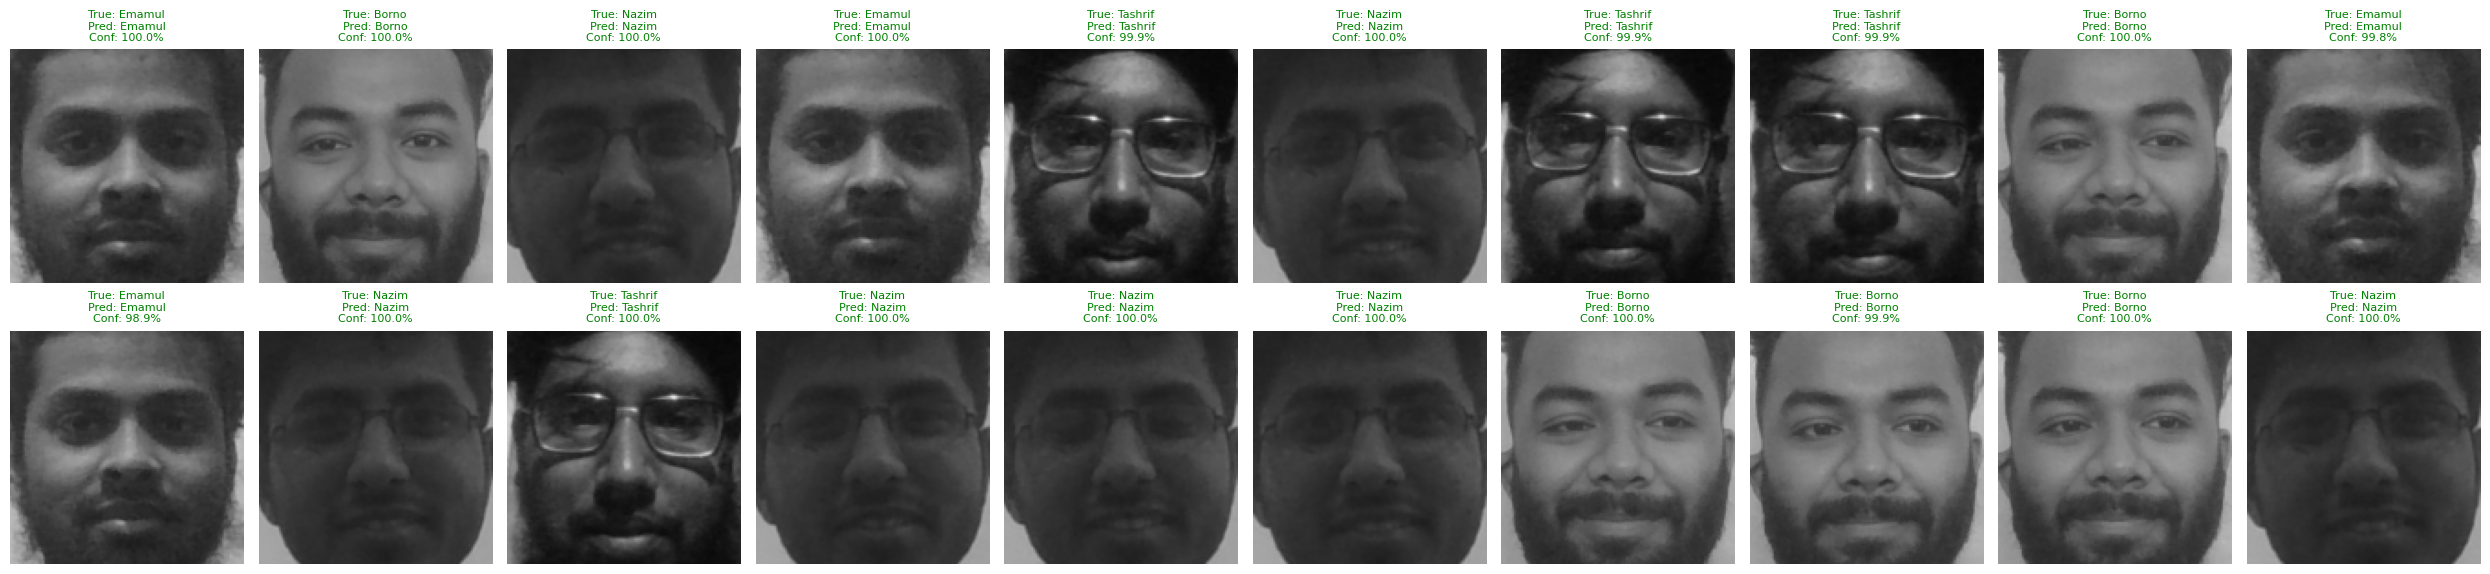

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# After training:
print("Training complete.")

# Predict on validation data
predictions = model.predict(X_val)

# Decode one-hot encoded labels
y_val_int = np.argmax(y_val, axis=1)

# Label index to name mapping
label_dict = {i: name for i, name in enumerate(le.classes_)}  # e.g., {0: 'Nazim', 1: 'Emamul', ...}

# Visualization function
def visualize_predictions(X_val, y_val_int, predictions, label_dict, num_images=150):
    num_images_to_show = min(num_images, len(X_val))
    num_cols = 10
    num_rows = (num_images_to_show + num_cols - 1) // num_cols
    plt.figure(figsize=(num_cols * 2.5, num_rows * 3))

    predicted_classes = np.argmax(predictions, axis=1)
    confidences = np.max(predictions, axis=1)

    for i in range(num_images_to_show):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(X_val[i])
        true_label = label_dict[y_val_int[i]]
        predicted_label = label_dict[predicted_classes[i]]
        confidence = confidences[i] * 100

        color = 'green' if true_label == predicted_label else 'red'

        plt.title(f'True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.1f}%',
                  color=color, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function correctly
visualize_predictions(X_val, y_val_int, predictions, label_dict, num_images=20)
